In [71]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder, OneHotEncoder, KBinsDiscretizer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV

from lightgbm import LGBMRegressor
import torch
import torch.nn as nn

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_squared_log_error, mean_absolute_percentage_error, median_absolute_error

In [72]:
target_col = 'close'

In [73]:
# Data created with data_import.ipynb
data_raw = pd.read_csv('data/data_model.csv')
data = data_raw.copy()

C:\Users\18327\AppData\Local\Temp\ipykernel_25564\1231830570.py:2: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  data_raw = pd.read_csv('data/data_model.csv')


In [207]:
# Group by 'ticker' and apply np.log to 'close' within each group
data['log_close'] = data.groupby('ticker')['close'].transform(np.log)

In [21]:
data.columns

Index(['datetime', 'open', 'high', 'low', 'close', 'volume', 'ticker',
       'Security', 'GICS Sector', 'GICS Sub-Industry',
       ...
       'momentum_ppo', 'momentum_ppo_signal', 'momentum_ppo_hist',
       'momentum_pvo', 'momentum_pvo_signal', 'momentum_pvo_hist',
       'momentum_kama', 'others_dr', 'others_dlr', 'others_cr'],
      dtype='object', length=101)

In [16]:
#TODO Fibonacci Levels

MemoryError: Unable to allocate 11.2 MiB for an array with shape (1472997,) and data type float64

In [74]:
# features = ['GICS Sector', 'ticker', 'ewma_extr_short', 'ewma_short', 'ewma_mid', 'ewma_extr_mid', 'ewma_long', 'ewma_extr_long', 'smoothed_rsi']
# data['smoothed_rsi'] = data['smoothed_rsi'].fillna(0)
data['7dClose'] = data.groupby('ticker')['close'].transform(lambda x: x.shift(7))
data.dropna(subset=['7dClose'], inplace=True)

target_col = '7dClose'
X = data.drop(target_col, axis=1)
y = data[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=X['GICS Sector'])

In [75]:
data.head()

,datetime,open,high,low,close,volume,ticker,Security,GICS Sector,GICS Sub-Industry,...,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr,7dClose
8,1999-11-30,28.30,28.93,27.58,28.42,3089700.0,A,Agilent Technologies,Health Care,Life Sciences Tools & Services,...,-1.042682,-0.417223,-40.728195,-23.490647,-17.237548,28.191116,0.140944,0.140845,-4.148398,29.65
9,1999-12-01,28.42,29.27,28.21,28.93,2115400.0,A,Agilent Technologies,Health Care,Life Sciences Tools & Services,...,-1.083620,-0.163751,-44.905676,-27.773653,-17.132023,28.473096,1.794511,1.778600,-2.428331,27.20
10,1999-12-02,29.48,30.32,29.10,29.73,2195900.0,A,Agilent Technologies,Health Care,Life Sciences Tools & Services,...,-1.035813,0.191229,-48.592044,-31.937331,-16.654713,28.942561,2.765296,2.727752,0.269815,29.65
11,1999-12-03,30.28,30.78,29.86,29.98,2175700.0,A,Agilent Technologies,Health Care,Life Sciences Tools & Services,...,-0.918945,0.467470,-51.870538,-35.923973,-15.946566,28.949744,0.840901,0.837386,1.112985,26.95
12,1999-12-06,30.49,31.29,30.45,30.83,1610000.0,A,Agilent Technologies,Health Care,Life Sciences Tools & Services,...,-0.716620,0.809300,-55.085795,-39.756337,-15.329458,29.126468,2.835223,2.795775,3.979764,27.67


In [76]:
def create_lgbm_pipeline(X):
    
    drop_cols = ['Security', 'ticker', 'CIK', 'Headquarters Location', 'Date added', 'Founded', 'founded_regex']
    
    X.drop(drop_cols, axis=1, inplace=True)
    
    # Identify numerical and categorical columns
    numerical_cols = X.select_dtypes(include=['number']).columns
    categorical_cols = X.select_dtypes(exclude=['number']).columns

    # Define preprocessing steps for numerical and categorical columns
    numerical_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])
    
    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    
    # Combine preprocessing steps using ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)
        ])

    # Create the pipeline with preprocessor and LightGBM Regressor
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', LGBMRegressor())
    ])

    return pipeline


In [77]:
pipeline = create_lgbm_pipeline(X_train)
pipeline.fit(X_train, y_train)
preds = pipeline.predict(X_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.476847 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44905
[LightGBM] [Info] Number of data points in the train set: 2690525, number of used features: 12011
[LightGBM] [Info] Start training from score 58.321597


In [78]:
# Calculate evaluation metrics on the test set
mse = mean_squared_error(y_test, preds)
mae = mean_absolute_error(y_test, preds)
r2 = r2_score(y_test, preds)

# Print the evaluation metrics
print("Mean Squared Error (MSE) on Test Set:", mse)
print("Mean Absolute Error (MAE) on Test Set:", mae)
print("R-squared (R2) on Test Set:", r2)

Mean Squared Error (MSE) on Test Set: 95.92597308416337
Mean Absolute Error (MAE) on Test Set: 1.3560964874910855
R-squared (R2) on Test Set: 0.9954955760754232


In [79]:
y_test.isna().sum()

0

In [81]:
base_cols = ['datetime', 'ticker', 'Security', 'GICS Sector', 'GICS Sub-Industry', 'Headquarters Location', 'open', 'high', 'low', 'volume', 'close', '7dClose', 'predicted_values']
result = pd.concat([X_test.reset_index(drop=True), y_test.reset_index(drop=True), pd.Series(preds, name='predicted_values')], axis=1).sort_values(['ticker', 'datetime'])[base_cols]

result

,datetime,ticker,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,open,high,low,volume,close,7dClose,predicted_values
645179,1999-12-01,A,Agilent Technologies,Health Care,Life Sciences Tools & Services,"Santa Clara, California",28.42000,29.27000,28.21,2115400.0,28.93000,27.20000,28.263418
435453,1999-12-07,A,Agilent Technologies,Health Care,Life Sciences Tools & Services,"Santa Clara, California",30.83000,30.99000,29.86,1585100.0,30.49000,27.75000,28.062409
478361,1999-12-13,A,Agilent Technologies,Health Care,Life Sciences Tools & Services,"Santa Clara, California",30.66000,31.16000,29.90,2875900.0,30.66000,29.73000,29.390662
637246,1999-12-16,A,Agilent Technologies,Health Care,Life Sciences Tools & Services,"Santa Clara, California",28.30000,32.34000,28.30,1848300.0,31.84000,30.49000,29.810803
256542,1999-12-27,A,Agilent Technologies,Health Care,Life Sciences Tools & Services,"Santa Clara, California",33.65000,35.84000,33.39,1451800.0,35.58000,28.09000,30.378589
...,...,...,...,...,...,...,...,...,...,...,...,...,...
130190,2024-03-12,ZTS,Zoetis,Health Care,Pharmaceuticals,"Parsippany, New Jersey",183.64999,183.83000,180.94,2598400.0,181.35001,190.82001,190.297825
124685,2024-03-14,ZTS,Zoetis,Health Care,Pharmaceuticals,"Parsippany, New Jersey",177.49001,177.49001,170.72,6432600.0,173.88000,185.23000,188.714170
597308,2024-03-15,ZTS,Zoetis,Health Care,Pharmaceuticals,"Parsippany, New Jersey",173.78000,175.50999,171.61,3399500.0,172.57001,183.53000,185.035215
147497,2024-03-22,ZTS,Zoetis,Health Care,Pharmaceuticals,"Parsippany, New Jersey",168.77000,171.36000,168.16,2840500.0,168.89999,176.23000,176.550292


In [84]:
result['up_down_org'] = np.where(result['7dClose'] >= result['close'], 'up', 'down')
result['up_down_pred'] = np.where(result['predicted_values'] >= result['close'], 'up', 'down')


In [83]:
result

,datetime,ticker,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,open,high,low,volume,close,7dClose,predicted_values
645179,1999-12-01,A,Agilent Technologies,Health Care,Life Sciences Tools & Services,"Santa Clara, California",28.42000,29.27000,28.21,2115400.0,28.93000,27.20000,28.263418
435453,1999-12-07,A,Agilent Technologies,Health Care,Life Sciences Tools & Services,"Santa Clara, California",30.83000,30.99000,29.86,1585100.0,30.49000,27.75000,28.062409
478361,1999-12-13,A,Agilent Technologies,Health Care,Life Sciences Tools & Services,"Santa Clara, California",30.66000,31.16000,29.90,2875900.0,30.66000,29.73000,29.390662
637246,1999-12-16,A,Agilent Technologies,Health Care,Life Sciences Tools & Services,"Santa Clara, California",28.30000,32.34000,28.30,1848300.0,31.84000,30.49000,29.810803
256542,1999-12-27,A,Agilent Technologies,Health Care,Life Sciences Tools & Services,"Santa Clara, California",33.65000,35.84000,33.39,1451800.0,35.58000,28.09000,30.378589
...,...,...,...,...,...,...,...,...,...,...,...,...,...
130190,2024-03-12,ZTS,Zoetis,Health Care,Pharmaceuticals,"Parsippany, New Jersey",183.64999,183.83000,180.94,2598400.0,181.35001,190.82001,190.297825
124685,2024-03-14,ZTS,Zoetis,Health Care,Pharmaceuticals,"Parsippany, New Jersey",177.49001,177.49001,170.72,6432600.0,173.88000,185.23000,188.714170
597308,2024-03-15,ZTS,Zoetis,Health Care,Pharmaceuticals,"Parsippany, New Jersey",173.78000,175.50999,171.61,3399500.0,172.57001,183.53000,185.035215
147497,2024-03-22,ZTS,Zoetis,Health Care,Pharmaceuticals,"Parsippany, New Jersey",168.77000,171.36000,168.16,2840500.0,168.89999,176.23000,176.550292


In [88]:
test_data = result[result['ticker'] == 'GOOGL']
# plt.plot(result['datetime'], result['close'])

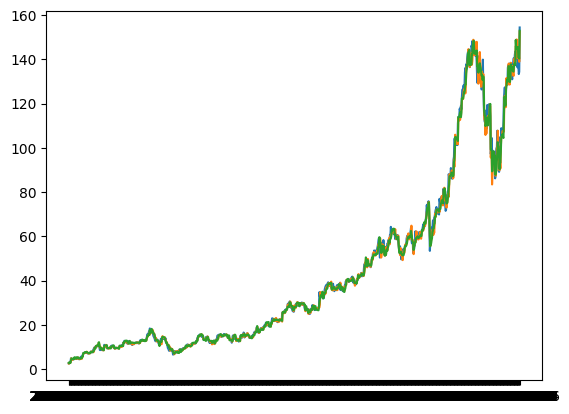

In [90]:
plt.plot(test_data['datetime'], test_data['close'], label='Close price')
plt.plot(test_data['datetime'], test_data['7dClose'], label='7dClose price')
plt.plot(test_data['datetime'], test_data['predicted_values'], label='Pred_7dClose price')

In [86]:
((result['up_down_org'] == result['up_down_pred']).sum()) / len(result)

0.8094188203951046